# Breast Cancer Data Challenge

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline, Pipeline

## Load Data

In [2]:
# Read in dataframe
df=pd.read_csv('breast-cancer-wisconsin.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [3]:
# Assign header names to each column
df.columns = ['ID','Thickness','Uniform_Size','Uniform_Shape','Adhesion','EpiCellSize','BareNuclei','Chromatin','Nucleoli','Mitoses','Class'] # assign column names
df['Class'] = df['Class'].map({2:0,4:1}) # assign benign value as 0 and malignant as 1
df.head()

,ID,Thickness,Uniform_Size,Uniform_Shape,Adhesion,EpiCellSize,BareNuclei,Chromatin,Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


## EDA

In [4]:
# Check number of null values
df.isnull().sum() 

ID               0
Thickness        0
Uniform_Size     0
Uniform_Shape    0
Adhesion         0
EpiCellSize      0
BareNuclei       0
Chromatin        0
Nucleoli         0
Mitoses          0
Class            0
dtype: int64

In [5]:
# Summary statistics of dataframe 
df.describe()

,ID,Thickness,Uniform_Size,Uniform_Shape,Adhesion,EpiCellSize,Chromatin,Nucleoli,Mitoses,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,0.344778
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.475636
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,0.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,1.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
ID               699 non-null int64
Thickness        699 non-null int64
Uniform_Size     699 non-null int64
Uniform_Shape    699 non-null int64
Adhesion         699 non-null int64
EpiCellSize      699 non-null int64
BareNuclei       699 non-null object
Chromatin        699 non-null int64
Nucleoli         699 non-null int64
Mitoses          699 non-null int64
Class            699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


In [7]:
# Pre-processing of dataframe 
df=df.drop(labels='ID',axis=1) # remove ID column
df = df[df['BareNuclei'] !='?'] # exclude rows with ?
df['BareNuclei'] = df['BareNuclei'].astype(int) # BareNuclei converted to integer 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 10 columns):
Thickness        683 non-null int64
Uniform_Size     683 non-null int64
Uniform_Shape    683 non-null int64
Adhesion         683 non-null int64
EpiCellSize      683 non-null int64
BareNuclei       683 non-null int64
Chromatin        683 non-null int64
Nucleoli         683 non-null int64
Mitoses          683 non-null int64
Class            683 non-null int64
dtypes: int64(10)
memory usage: 58.7 KB


## EDA Plotting

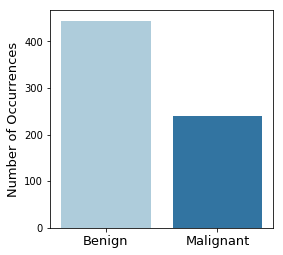

In [8]:
# Histogram for the two classes (benign and malignant) is first constructed to check for class imbalance
fig = plt.figure(figsize=(4, 4))
ax = sns.countplot(x='Class',data=df, palette="Paired")
ax.set_xticklabels(['Benign','Malignant'], fontsize=13)
ax.set_xlabel('')
ax.set_ylabel('Number of Occurrences', fontsize=13);

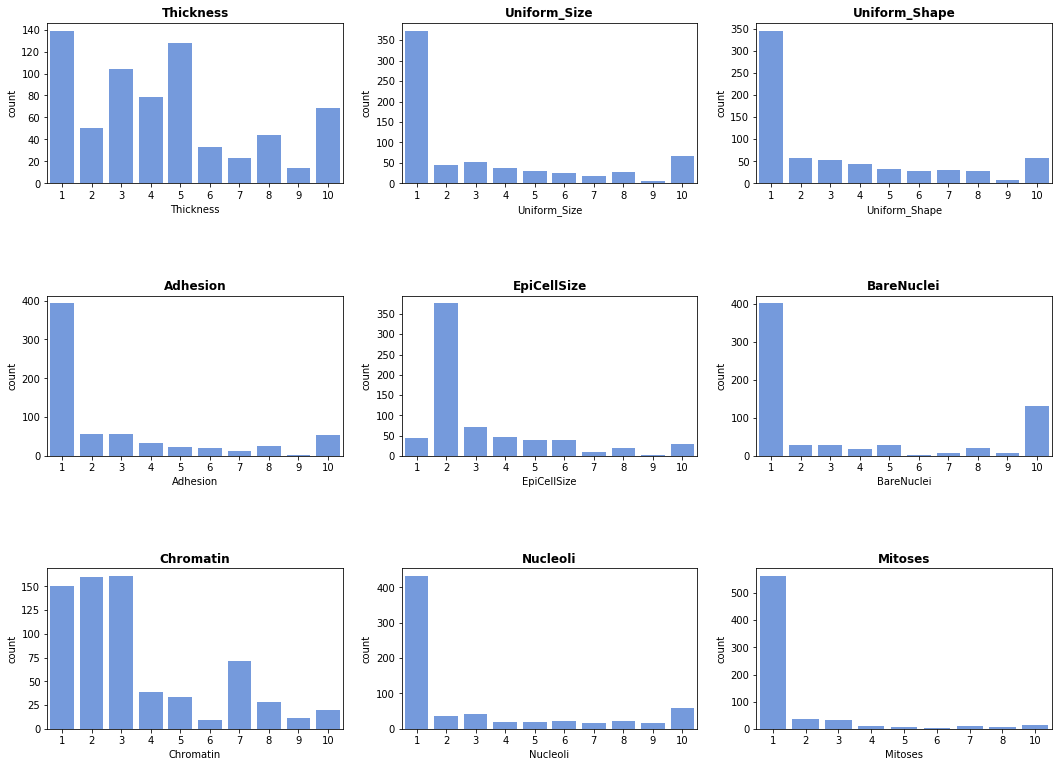

In [9]:
# Histograms to observe distribution of all features across both classes are plotted
fig = plt.figure(figsize=(18, 18))
cols = 3
rows = np.ceil(float(df.shape[1]) / cols)
for i, column in enumerate(df.columns[:-1]):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column, weight='bold')
    sns.countplot(x=column,data=df, color='cornflowerblue')
plt.subplots_adjust(hspace=0.7, wspace=0.2)

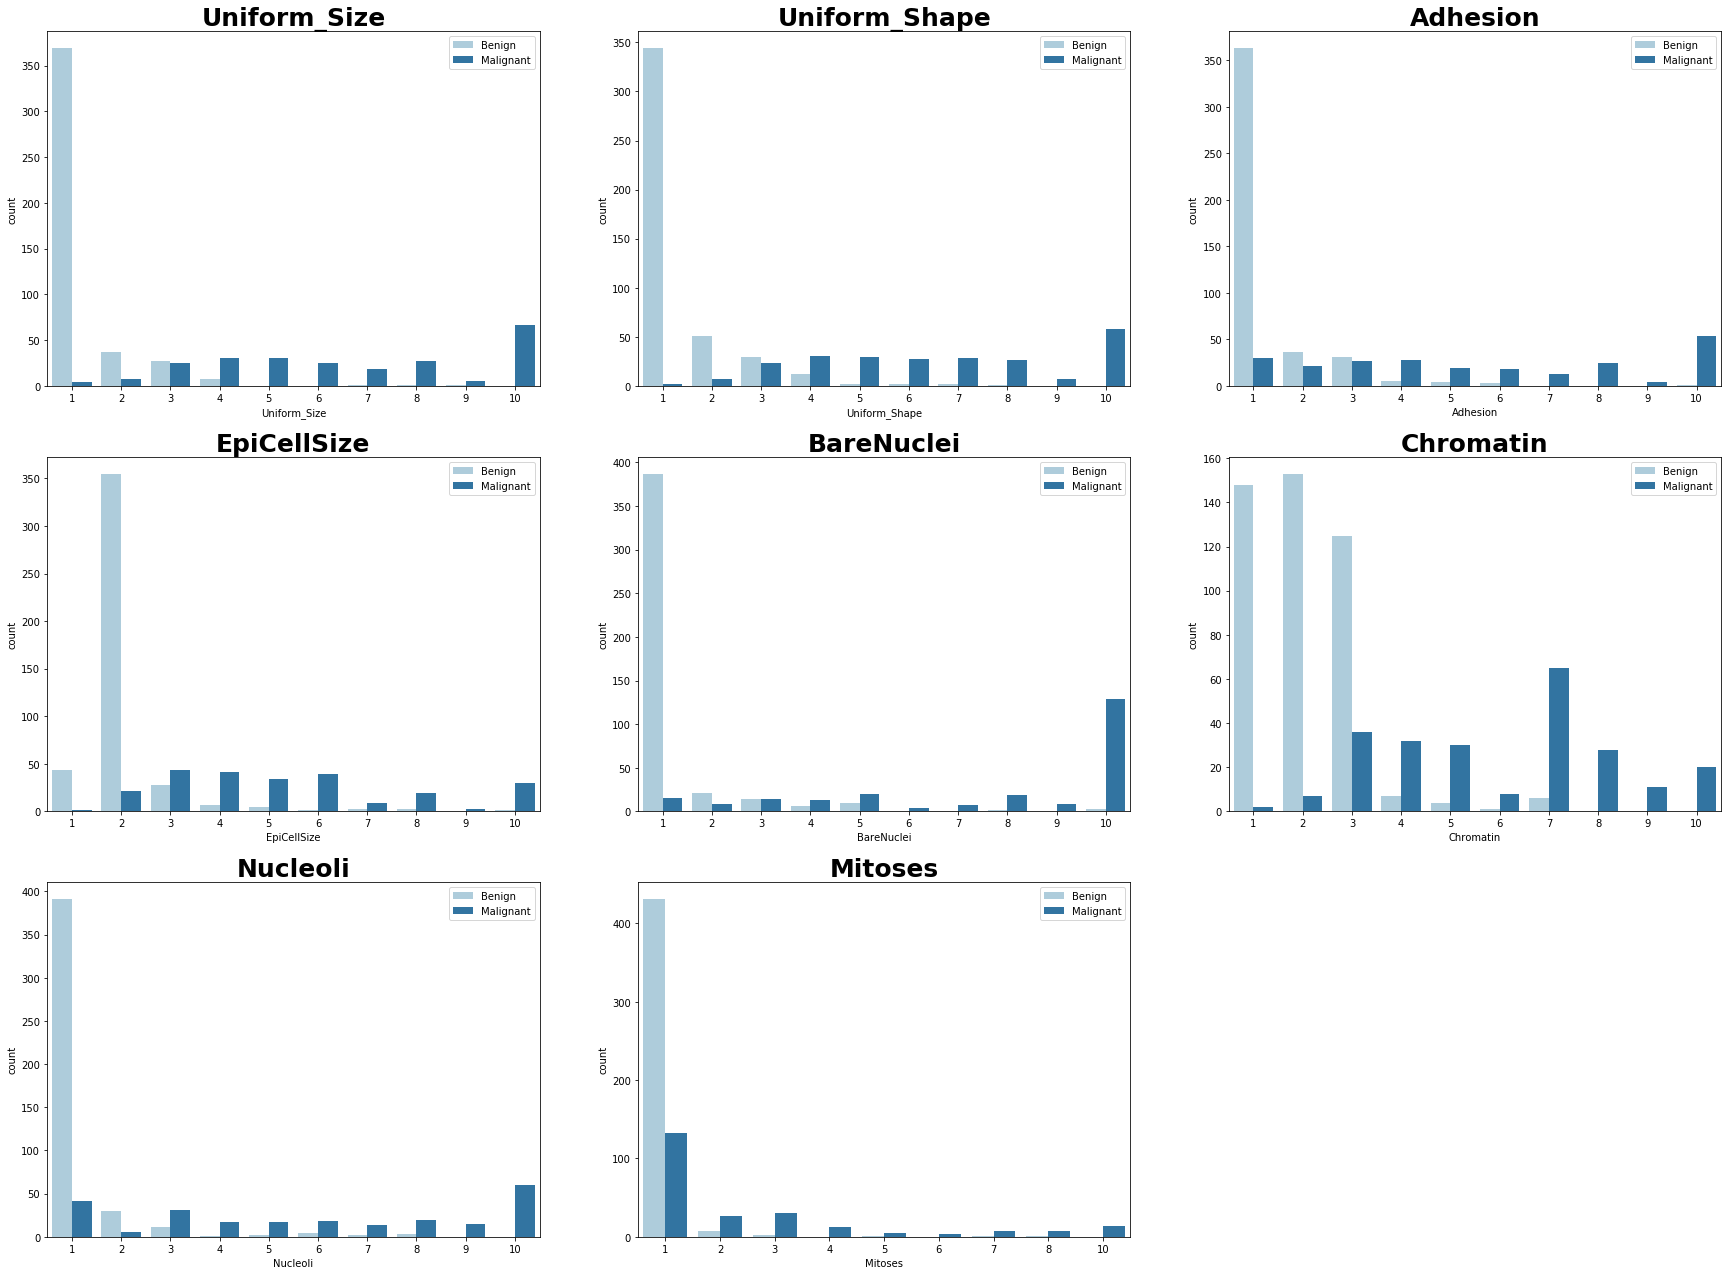

In [10]:
# Histograms to observe distribution of all features for each class is plotted
fig = plt.figure(figsize=(30, 30))
cols = 3
rows = np.ceil(float(df.shape[1]) / cols)

for i,column in enumerate(df.columns[1:len(df.columns)-1]):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(column, fontsize=25, weight='bold')
    sns.countplot(x=column, hue='Class', palette="Paired", data=df)
    plt.legend(labels=['Benign', 'Malignant'], loc = 1)

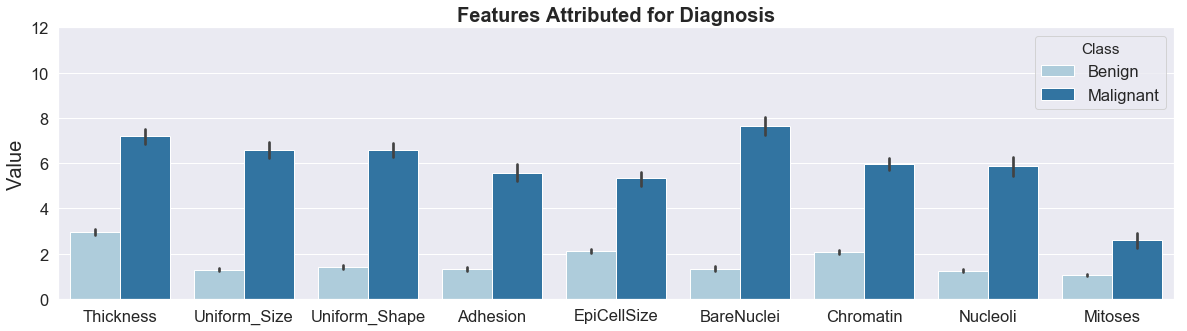

In [11]:
# Average values for each class are plotted as bar plots across both classes 
merged = pd.melt(df,id_vars="Class",
                    var_name="features",
                    value_name='value')

merged['Class'] = merged['Class'].map({0:'Benign',1:'Malignant'}) # benign = 0, malignant = 1

sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(20, 5))
fig = sns.barplot(x="features", y="value", hue="Class", data=merged, palette="Paired")
fig.axis(ymin=0, ymax=12);

new_labels = ['Benign', 'Malignant']

ax.set_xlabel('', fontsize=15)
ax.set_ylabel('Value', fontsize=20)
ax.set_title('Features Attributed for Diagnosis', fontsize = 20, weight='bold');

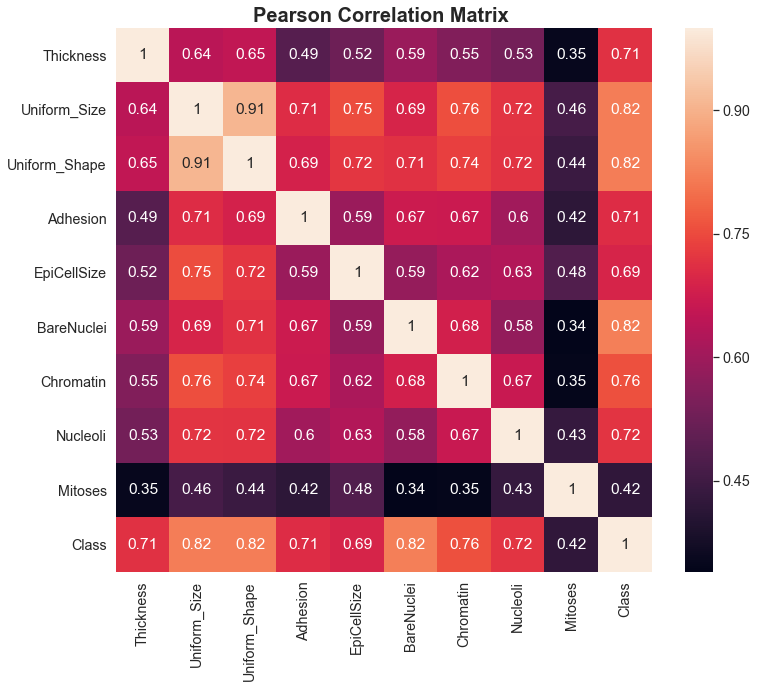

In [12]:
# Pearson Correlation Matrix across features and classes were plotted  
corr = df.corr()
sns.set(font_scale = 1.3)
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr,annot = True);
ax.set_title('Pearson Correlation Matrix ', fontsize = 20, weight='bold');

## Implement Classifier Model

In [13]:
# Preparing dataframe for modeling 
X = df 
X = X.drop('Class',axis=1) # removing class from the design matrix
Y = df['Class'] # setting Y as the labels

# Splitting Train and Testing datasets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=17)

In [14]:
# Initialize SMOTE to correct for class imbalance
sm = SMOTE()

# Random Forest Classifier
rf = RandomForestClassifier()

# Generate a pipeline with SMOTE and RF
pipeline = Pipeline([('sm', sm), ('rf', rf)])

# Grid search parameters for RF
params = {'rf__max_depth' : list(range(2,5)),
          'rf__max_features' : ['auto'],
          'rf__bootstrap' : [True, False],
          'rf__n_estimators' : [10, 20, 50, 100],
          'rf__min_samples_leaf': [5, 10, 15, 20],
          'rf__max_features': [2, 4, 6, 8]}

# Perform Grid Search
grid_rf = GridSearchCV(pipeline, params, cv = 3)
grid_rf.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('sm',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=None, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('rf',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',...
                                                               oob_score=False,
                              

## Evaluation of Model

In [15]:
# Computation of random forest accuracy
forest_pred=grid_rf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, forest_pred))

Accuracy: 0.9707317073170731


In [16]:
# Defining confusion matrix function
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label', weight='bold', fontsize=16)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), weight='bold', fontsize=16)
    plt.show()

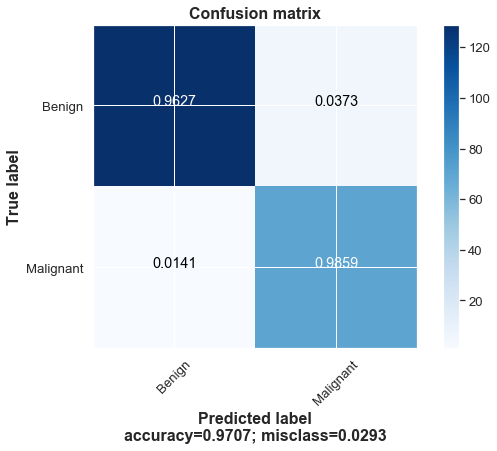

In [17]:
Forest_Confusion = confusion_matrix(y_test, forest_pred) # construct confusion matrix 
sns.set(font_scale = 1.2)
plot_confusion_matrix(Forest_Confusion, target_names=['Benign','Malignant'])

## Feature Importance

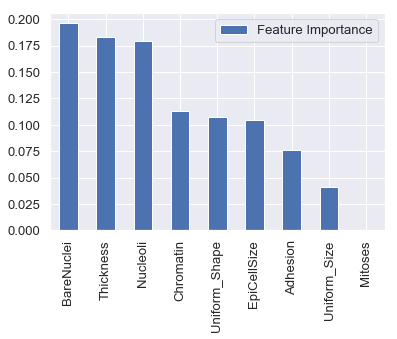

In [18]:
# Extracting feature importance from random forest model
feature_importances = pd.DataFrame(grid_rf.best_estimator_.named_steps["rf"].feature_importances_, index = X.columns, columns=['Feature Importance']).sort_values('Feature Importance', ascending=False)    
feature_importances.plot.bar()
sns.set(font_scale = 1)


## ROC and PR Curves

In [23]:
# Calculation of ROC metrics
forest_probs = grid_rf.predict_proba(x_test) # predict probability result of each class
forest_probs2 = forest_probs[:, 1]

fprforest2, tprforest2, thresholdforest2 = roc_curve(y_test, forest_probs2)
forest_roc_auc = metrics.auc(fprforest2, tprforest2)

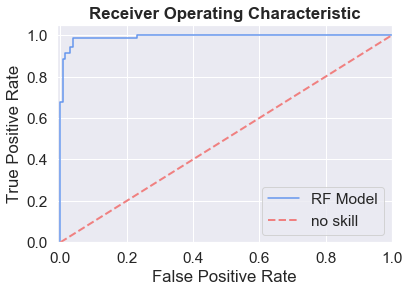

In [24]:
# Plotting ROC curve
plt.figure()
sns.set(font_scale = 1.4)
plt.plot(fprforest2, tprforest2, color='cornflowerblue')
plt.plot([0, 1], [0, 1], color='lightcoral', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic', weight='bold')
plt.legend(labels = ['RF Model', 'no skill'], loc="lower right")
plt.show()

In [25]:
# Calculation of F1 score and AUC and average Precision Score 
precision, recall, thresholds = precision_recall_curve(y_test, forest_probs2)
f1 = f1_score(y_test, forest_pred) # calculate F1 score
auc_disp = auc(recall, precision) # calculate precision-recall AUC
ap = average_precision_score(y_test, forest_probs2) # calculate average precision score
print('f1-score=%.3f auc=%.3f ap=%.3f' % (f1, auc_disp, ap))

f1-score=0.959 auc=0.987 ap=0.987
